# To-do list
1. Migrate code for doing dense $\chi^2$ (and related) calculations to remote branch of code base.
2. Write Woodbury inversion routine and efficient determinant calculation routine. Also write unit tests.
    * Regarding determinant calculation: Note that we have for $m \times m$ $A$ and $m \times n$ $U, V$, $\det(A + UV^T) = \det(\mathbb{1}_m + V^T A^{-1} U)\det(A)$. The way to implement this efficiently is to write $C = A + G\sigma \sigma^\dagger G^\dagger$, with $A = N + GD D^\dagger G^\dagger$. Since $DD^\dagger$ is block-diagonal (and hence $GD D^\dagger G^\dagger$ is also block-diagonal), the determinant is just the product of the determinants of the blocks. The $\det(A)$ calculation can also probably be made a bit more efficient by again employing the matrix determinant lemma. That said, for large arrays, floating point precision might crop up as an issue. It might be more stable to calculate the small matrices, take the Cholesky decomposition, then use that to calculate the determinant (since we really only care about $\log\det C$, and this should be relatively stable when using the Cholesky decomposition).
3. Redo the tests in the `Testing` notebook with the sparse formulation and ensure they give the same results. It might be worthwhile to think about making a unit test comparing the solutions for the two schemes.
4. For some simulated data, create a mesh of redundant visibilities and gains centered on the truth. Check that the $\chi^2$ hypersurface for the redcal $\chi^2$ has the same minimum as that of the redundant limit of the corrcal $\chi^2$. It might be better to do this in a standalone notebook.

In [4]:
import numpy as np
import corrcal
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fmin_cg
from pyuvdata import UVData
from pathlib import Path
import os
from astropy import constants
from hera_sim import Simulator
from hera_sim.antpos import HexArray
from numba import njit, prange
from line_profiler import LineProfiler
import warnings
%matplotlib inline

## TODO
Profile the code using `memray`. I think this requires porting this code to a script.

## Inverse Testing

In [5]:
# Just do it the stupid way first.
class SparseCov:
    def __init__(self, noise, gains, src_mat, diff_mat, edges):
        self.noise = noise  # just the diagonal
        self.gains = gains  # gain matrix for now, but just the diagonal
        self.src_mat = src_mat
        self.diff_mat = diff_mat
        self.edges = edges
        self.n_grp = edges.size - 1
        self.n_src = src_mat.shape[1]
        self.n_eig = diff_mat.shape[1] // self.n_grp
        self.n_bls = diff_mat.shape[0]
    
    def inv(self, return_det=False):
        # Make some auxiliary quantities
        if return_det:
            logdet = 0
#         N_inv = 1 / self.noise  # remember this is still just the diagonal
        GD = self.gains[:,None] * self.diff_mat  # this is faster than doing matmul
        diff_I = np.eye(self.n_eig)
        
        # (N)GD have shape (n_bls, Nred*Neig)
#         tmp = np.zeros((self.n_grp, self.n_eig, self.n_eig), dtype=complex)
  
        # If we're assuming that redundant groups are independent of each other, then
        # there isn't really much reason to do Woodbury like this (since we'll just be
        # doing small inverses of the redundant blocks).
        Cinv = np.zeros((self.n_bls, self.n_bls), dtype=complex)
        for i, (start, stop) in enumerate(zip(self.edges, self.edges[1:])):
            left = i * self.n_eig
            right = (i+1) * self.n_eig
            block = GD[start:stop,left:right].copy()
            block = np.diag(self.noise[start:stop]) + block @ block.T.conj()
            if return_det:
                logdet += 2 * np.log(np.diag(np.linalg.cholesky(block))).sum()
            Cinv[start:stop,start:stop] = np.linalg.inv(block)
        # Need to broadcast tmp to n_bls x n_bls array.
#         # This part can probably be parallelized.
#         # Form I + DGNinvGD for each redundant block then invert.
#         for i, (start, stop) in enumerate(zip(self.edges, self.edges[1:])):
#             left = i * self.n_eig
#             right = (i+1) * self.n_eig
#             tmp[i] = diff_I + GD[start:stop,left:right].T.conj() @ NGD[start:stop,left:right]
#         tmp = np.linalg.inv(tmp)
#         if return_det:
#             # On a closer look, I don't actually expect this to work.
#             tmp2 = np.linalg.cholesky(tmp)
#             logdet += np.log(np.diagonal(tmp2, axis1=1, axis2=2).flatten()).sum()
#             del tmp2
        
#         # Maybe this part too.
#         # Do the remaining matrix multiplications to finish the first inversion.
#         Cinv = np.zeros((self.n_bls, self.n_bls), dtype=complex)
#         for i, (start, stop) in enumerate(zip(self.edges, self.edges[1:])):
#             left = i * self.n_eig
#             right = (i+1) * self.n_eig
#             tmp2 = NGD[start:stop, left:right]
#             Cinv[start:stop,start:stop] = tmp2 @ tmp[i] @ tmp2.T.conj()
#         Cinv = np.diag(N_inv) - Cinv
        
        # Second Woodbury inversion
        GS = self.gains[:,None] * self.src_mat
#         GS = GS.real + 1j*GS.imag
        src_I = np.eye(self.n_src)
        CGS = Cinv @ GS
        tmp = src_I + GS.T.conj() @ CGS
        Cinv = Cinv - CGS @ np.linalg.inv(tmp) @ CGS.T.conj()
        if return_det:
            tmp = np.linalg.cholesky(tmp)
            logdet += 2 * np.log(np.diag(tmp)).sum()
            return Cinv, np.real(logdet)
        return Cinv

In [6]:
# Mock up some data.
sample_file = "small.sum.true.uvh5"
uvdata = UVData()
uvdata.read(sample_file)
# uvdata.select(antenna_nums=np.array([67,68,69,70,37,38,39,40,11,12,13,14,52,53,54,24,25,26]), keep_all_metadata=False)
# Extract data/metadata for a single integration/channel.
t0 = uvdata.time_array[0]
nu0 = uvdata.freq_array.flatten()[0]
uvdata.select(times=np.array([t0]), frequencies=np.array([nu0]), polarizations=np.array(['xx']))

Telescope RIMEz calculation is not in known_telescopes.


In [7]:
# sim = Simulator(data=uvdata)

In [83]:
def square_array(N, sep=14):
    array = {}
    ant = 0
    for i in range(N):
        for j in range(N):
            array[ant] = np.array([i*sep, j*sep, 0])
            ant += 1
    return array

In [8]:
array = HexArray(split_core=False, outriggers=0)

In [200]:
sim = Simulator(
    array_layout=square_array(3),
    Ntimes=1,
    start_time=2458055.3,
    integration_time=10.7,
    Nfreqs=1,
    start_freq=150e6,
    channel_width=97751.71065492928,
)

In [201]:
uvdata = sim.data

In [202]:
# Pull some metadata for slicing through the array
ant_1_array = uvdata.ant_1_array
ant_2_array = uvdata.ant_2_array
antpos, antnums = uvdata.get_ENU_antpos()
ant_1_inds = np.zeros_like(ant_1_array)
ant_2_inds = np.zeros_like(ant_2_array)
for i, ant in enumerate(antnums):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

In [203]:
# Rather than use actual data, take a single source at a fixed position.
src_za = np.array([4 * np.pi / 5, 0 * np.pi / 3])
src_az = np.array([np.pi / 3, 5 * np.pi / 3])
src_flux = np.array([5, 2], dtype=float)
src_loc = np.array(
    [
        [np.sin(za)*np.cos(az), np.sin(za)*np.sin(az), np.cos(za)]
        for za, az in zip(src_za, src_az)
    ]
)
for i, (ai, aj) in enumerate(zip(ant_1_inds, ant_2_inds)):
    bl = antpos[aj] - antpos[ai]
    sim.data.data_array[i,...] = np.sum(
        src_flux * np.exp(
            -2j * np.pi * nu0 * src_loc @ bl / constants.c.si.value
        )
    )

In [204]:
Trx = np.min(src_flux) / 100
# channel_width = np.median(sim.data.channel_width)
# integration_time = np.median(sim.data.integration_time)
integration_time = 10.7
channel_width = 97751.71065492928
sim.add(
    "thermal_noise",
    Trx=Trx,
    omega_p=np.ones_like(sim.freqs)*2*np.pi,
    autovis=src_flux.sum(),
    channel_width=channel_width,
    integration_time=integration_time,
)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


In [205]:
uvdata.select(ant_str="cross")

In [206]:
# Pull the data array and the antenna metadata again.
data = uvdata.data_array[:,0,0,0].copy()
ant_1_array = uvdata.ant_1_array
ant_2_array = uvdata.ant_2_array
antpos, antnums = uvdata.get_ENU_antpos()
ant_1_inds = np.zeros_like(ant_1_array)
ant_2_inds = np.zeros_like(ant_2_array)
for i, ant in enumerate(antnums):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

In [207]:
# Sort the data into redundant groups.
wavelength = constants.c.si.value / nu0
uvws = (antpos[ant_2_inds] - antpos[ant_1_inds]) / wavelength
sort, edges, conj = corrcal.gridding.make_redundant_groups(*uvws.T[:2])
sorted_uvws = uvws[sort,:]
sorted_uvws[conj,:] *= -1
sorted_ant_1_inds = ant_1_inds[sort]
sorted_ant_2_inds = ant_2_inds[sort]
tmp = sorted_ant_1_inds.copy()
sorted_ant_1_inds[conj] = sorted_ant_2_inds[conj]
sorted_ant_2_inds[conj] = tmp[conj]
sorted_data = data[sort]
sorted_data[conj] = sorted_data[conj].conj()

In [208]:
# Insert a small amount of noise for invertibility.
Jy2T = 1e-26 * wavelength**2 / (2*constants.k_B.si.value*2*np.pi)
noise_amp = (src_flux.sum() + Trx/Jy2T)**2 / (channel_width*integration_time)
# noise_amp = 0.1
noise = np.eye(data.size, dtype=complex) * noise_amp
# noise = np.eye(data.size) * (1+1j) * noise_amp / 4

# Mock up a covariance matrix.
n_groups = edges.size - 1
n_bls = data.size
n_src = src_flux.size
diff_mat_amp = np.sum(src_flux)
diff_mat = np.zeros((n_bls, n_groups), dtype=complex)
for col, (start, stop) in enumerate(zip(edges, edges[1:])):
    diff_mat[start:stop,col] = diff_mat_amp
diff_cov = diff_mat @ diff_mat.T.conj()
bls = antpos[sorted_ant_2_inds] - antpos[sorted_ant_1_inds]
src_mat = src_flux.reshape(1, -1) * np.exp(
    -2j * np.pi * nu0 * bls @ src_loc.T / constants.c.si.value
)
src_cov = src_mat @ src_mat.T.conj()

# Now mock up antenna gains.
n_ants = antnums.size
err = 0.05
re_gain = np.random.normal(loc=1, scale=err, size=n_ants)
im_gain = np.random.normal(loc=0, scale=err, size=n_ants)
gains = re_gain + 1j*im_gain
gain_mat = gains[sorted_ant_1_inds] * gains[sorted_ant_2_inds].conj()
gain_mat = np.diag(gain_mat)

In [209]:
mat = SparseCov(np.diag(noise), np.diag(gain_mat), src_mat, diff_mat, edges)

In [210]:
def nll(gains, cov, data, ant_1_inds, ant_2_inds, scale=1, grad_scale=None):
    n_ants = gains.size // 2
    gains = gains[:n_ants] + 1j*gains[n_ants:]
    gains /= scale
    cov.gains = gains[ant_1_inds] * gains[ant_2_inds].conj()
    cinv, logdet = cov.inv(return_det=True)
    chisq = data.conj() @ cinv @ data
    if np.abs(chisq.imag/chisq.real) > 1e-8:
        warnings.warn("Chi-squared isn't purely real.")
    return np.real(chisq + logdet)

In [211]:
nll(np.concatenate([re_gain, im_gain]), mat, sorted_data, ant_1_inds, ant_2_inds)

188.6610200978617

Look into which parts of the inversion routine actually give speedups. i.e. can we just do a quick inversion of the block-diagonal parts of N + GDDG? See https://arxiv.org/abs/1612.03255 section 4 for potentially helpful reference.

In [212]:
minv = mat.inv()

In [213]:
full_cov = noise + gain_mat @ src_cov @ gain_mat.conj() + gain_mat @ diff_cov @ gain_mat.conj()
cinv = np.linalg.inv(full_cov)

In [214]:
np.allclose(minv, cinv)

False

In [215]:
minv, det = mat.inv(True)

In [216]:
# full_cov = noise + gain_mat @ src_cov @ gain_mat.conj() + gain_mat @ diff_cov @ gain_mat.conj()
dense_det = 2 * np.log(np.diag(np.linalg.cholesky(full_cov))).sum()

In [217]:
det, dense_det

(-54.15089062416808, (-53.826670262928786+0j))

In [218]:
# %%timeit
# minv = mat.inv()

In [219]:
# %%timeit
# minv, det = mat.inv(True)

## Determinant Testing

In [220]:
m = 5
n = 5
small_mats = np.array([np.random.normal(size=(m,m)) for _ in range(n)])
big_mat = np.zeros((m*n,)*2)
for i, mat in enumerate(small_mats):
    here = (slice(i*m,(i+1)*m),)*2
    big_mat[here] = mat

In [221]:
d1 = np.linalg.det(big_mat)

In [222]:
d2 = np.prod(np.linalg.det(small_mats))

In [223]:
np.isclose(d1, d2)

True

The above cells show that the determinant of a block-diagonal matrix is the product of the determinant of each block (this should be obvious from the definition of the determinant, but it's nice to test numerically).

In [224]:
m = 10
n = 50
small_mats = np.array([np.random.normal(size=(m,m)) for _ in range(n)])
small_mats = np.array([mat @ mat.T for mat in small_mats])
big_mat = np.zeros((m*n,)*2)
for i, mat in enumerate(small_mats):
    here = (slice(i*m,(i+1)*m),)*2
    big_mat[here] = mat

In [225]:
# do the logdet 3 ways
ld1 = np.log(np.linalg.det(big_mat))

In [226]:
ld2 = np.log(np.linalg.det(small_mats)).sum()

In [227]:
L = np.linalg.cholesky(small_mats)
ld3 = 2*np.log(np.diagonal(L, axis1=1, axis2=2).flatten()).sum()

In [228]:
np.allclose(ld1, ld2, ld3)

True

In [229]:
# Now test the Matrix Determinant Lemma
n = 50
m = 20
A = np.random.normal(size=(n,n)) + 1j*np.random.normal(size=(n,n))
A = A @ A.T.conj()
U = np.random.normal(size=(n,m)) + 1j*np.random.normal(size=(n,m))
V = np.random.normal(size=(n,m)) + 1j*np.random.normal(size=(n,m))
C = A + U @ V.T.conj()

In [230]:
d1 = np.linalg.det(C)

In [231]:
d2 = np.linalg.det(np.eye(m) + V.T.conj() @ np.linalg.inv(A) @ U) * np.linalg.det(A)

In [232]:
np.isclose(d1, d2)

True

In [233]:
uvdata.Nants_data

9

In [234]:
# %%timeit
# GS = gain_mat @ src_mat
# GD = gain_mat @ diff_mat
# full_cov = noise + GS @ GS.conj().T + GD @ GD.conj().T
# L = np.linalg.cholesky(full_cov)
# direct_det = 2 * np.log(np.diag(L)).sum()

In [235]:
dense_scaling = {7: 60.6e-6, 19: 1.26e-3, 37: 30.9e-3, 61: 355e-3}
sparse_scaling = {7: 194e-6, 19: 2.8e-3, 37: 77.2e-3, 61: 1.2}

In [236]:
# %%timeit
# ld1 = np.log(np.diag(noise)).sum()
# Ninv = np.diag(1/np.diag(noise))
# NGD = Ninv @ gain_mat @ diff_mat
# Cinv = np.eye(NGD.shape[1], dtype=complex) + np.conj(gain_mat @ diff_mat).T @ NGD
# Cinv = np.linalg.cholesky(Cinv)
# ld2 = 2 * np.log(np.diag(Cinv)).sum()
# Cinv = np.linalg.inv(Cinv)
# NGD = NGD @ Cinv.conj().T
# Cinv = Ninv - NGD @ NGD.conj().T
# Cinv = np.linalg.cholesky(Cinv)
# CGS = Cinv @ gain_mat @ src_mat
# Cinv = np.eye(CGS.shape[1], dtype=complex) + CGS.conj().T @ CGS
# Cinv = np.linalg.cholesky(Cinv)
# ld3 = 2 * np.log(np.diag(Cinv)).sum()
# other_det = ld1 + ld2 + ld3
# # This works!

Main takeaway: we don't do better in performance when isolating the determinant calculation (when *not* doing the block diagonal calculations carefully); however, everything we need to calculate the determinant is calculated during inversion, so we can get the determinant for free during the inversion routine.

Next thing to do: write down the algorithm for the sparse gradient calculation.

Here's the gist of it:
<br><br>
We can write the gradient like so:
<br><br>
$$
-\nabla \log\mathcal{L} = {\rm Tr}(C^{-1}\nabla C) - \tilde{d}^\dagger \nabla C \tilde{d},
$$
<br>
where $\tilde{d} \equiv C^{-1} d$. We can calculate the trace term as the sum of the element-wise product of $C^{-1}$ and $\nabla C^T$; this scales like $\mathcal{O}(N_\rm{bl}^2)$. $C^{-1}$ can be calculated as usual. Until it becomes relevant, let's treat separate redundant groups as statistically independent (i.e. the "diffuse" term is block-diagonal). The gradient of the covariance can be written as
<br><br>
$$
\nabla C = \nabla G C^{\rm sky} G^\dagger + \bigl(\nabla G C^{\rm sky} G^\dagger\bigr)^\dagger,
$$
<br>
with $C^{\rm sky} \equiv \sigma\sigma^\dagger + DD^\dagger$. If the matrix multiplications are done cleverly, it should scale like $\mathcal{O}\bigl(N_{\rm bl} \max(N_{\rm red}N_{\rm eig}, N_{\rm src})\bigr)$. The gradient, written in terms of complex numbers, takes the following form:
<br><br>
$$
\begin{align}
    \frac{\partial G_k}{\partial {\rm Re}g_j} &= \delta_{k_1 j} g_{k_2}^* + \delta_{k_2 j} g_{k_1} \\
    \frac{\partial G_k}{\partial {\rm Im}g_j} &= i\bigl( \delta_{k_1 j} g_{k_2}^* - \delta_{k_2 j} g_{k_1}\bigr)
\end{align}
$$

$$
G_k = g_{k_1} g_{k_2}^* = ({\rm Re}g_{k_1} + i{\rm Im}g_{k_1})g_{k_2}^* = g_{k_1}({\rm Re}g_{k_2} - i{\rm Im}g_{k_2}) \\
G_k^* = g_{k_1}^* g_{k_2} = ({\rm Re}g_{k_1} - i{\rm Im}g_{k_1})g_{k_2} = g_{k_1}^*({\rm Re}g_{k_2} + i{\rm Im}g_{k_2})
$$

In [237]:
profiler = LineProfiler()

In [238]:
# @profiler
def grad_nll(gains, cov, data, ant_1_inds, ant_2_inds, scale=1):
    n_ants = gains.size // 2
    gains = gains[:n_ants] + 1j*gains[n_ants:]
    gains /= scale
    gain_mat = gains[ant_1_inds] * gains[ant_2_inds].conj()
    cov.gains = gain_mat
    cinv = cov.inv()
    gradient = np.zeros(2*n_ants, dtype=float)
    d_tilde = cinv @ data
    src_rhs = cov.src_mat.T.conj() * cov.gains[None,:].conj()
    diff_rhs = cov.diff_mat.T.conj() * cov.gains[None,:].conj()
    gain_mat_grad = np.zeros_like(gain_mat)
    cov_grad = np.zeros_like(cinv)
    for ant in range(n_ants):
        for i, sl in enumerate((slice(None,n_ants), slice(n_ants,None))):
            delta_ant1 = ant_1_inds == ant
            delta_ant2 = ant_2_inds == ant
            gain_mat_grad[:] = 0
            if i == 0:  # Gradient w.r.t. real part of gains
                gain_mat_grad[delta_ant1] += gains[ant_2_inds][delta_ant1].conj()
                gain_mat_grad[delta_ant2] += gains[ant_1_inds][delta_ant2]
            else:
                gain_mat_grad[delta_ant1] += 1j * gains[ant_2_inds][delta_ant1].conj()
                gain_mat_grad[delta_ant2] += -1j * gains[ant_1_inds][delta_ant2]
            
            cov_grad[...] = 0
            lhs = gain_mat_grad[:,None] * cov.src_mat
            cov_grad += lhs @ src_rhs
            lhs = gain_mat_grad[:,None] * cov.diff_mat
            cov_grad += lhs @ diff_rhs
            cov_grad += cov_grad.T.conj()
            
            grad_norm = np.sum(cinv * cov_grad)
            grad_chisq = -d_tilde.conj() @ cov_grad @ d_tilde
            grad = grad_norm + grad_chisq
                
            if np.abs(grad.imag / grad.real) > 1e-8:
                print("Gradient isn't purely real!")
            gradient[sl][ant] = grad.real
    return gradient / scale

In [239]:
mat = SparseCov(np.diag(noise), np.diag(gain_mat), src_mat, diff_mat, edges)

In [240]:
n_ants

9

In [241]:
profiler.print_stats()

Timer unit: 1e-06 s



In [242]:
grad_nll(np.concatenate([re_gain, im_gain]), mat, sorted_data, ant_1_inds, ant_2_inds)

array([ 1.27327300e+03,  2.66017375e+02,  1.25765481e+02,  1.78232359e+02,
       -3.64629355e+02,  1.53867713e+03, -1.05304780e+02, -2.13055310e+03,
        2.56234072e+03,  1.98383349e+03, -5.73513769e-01,  1.98871984e+03,
        6.75494706e+03,  4.43111547e+03, -2.95004210e+03, -6.73604302e+03,
       -1.99003166e+03, -3.77141067e+03])

In [243]:
scale = 1
args = (mat, sorted_data, sorted_ant_1_inds, sorted_ant_2_inds, scale)
fit_gains, steps = fmin_cg(
    nll,
#     fit_gains,
    corrcal.linalg.SplitVec(scale*(re_gain+1j*im_gain)).data,
    fprime=grad_nll,
    args=args,
    maxiter=40,
    retall=True,
)

         Current function value: -32.036514
         Iterations: 8
         Function evaluations: 83
         Gradient evaluations: 71


In [244]:
(fit_gains[:n_ants]+1j*fit_gains[n_ants:]) / scale

array([1.02898879+0.03158486j, 1.01392002+0.0288785j ,
       1.02487005+0.02562218j, 1.01404833-0.00023106j,
       1.02880245-0.00618691j, 1.01362425-0.00733083j,
       1.02799632-0.03420675j, 1.02944558-0.03742319j,
       1.01550968-0.04101136j])

In [245]:
complex_fit = (fit_gains[:n_ants]+1j*fit_gains[n_ants:]) / scale
guess = re_gain + 1j*im_gain

In [246]:
test_gains = np.concatenate([gains.real, gains.imag])

In [247]:
gradient = grad_nll(test_gains, *args[:-1])

In [248]:
resid = corrcal.linalg.SplitVec(1-gains).data

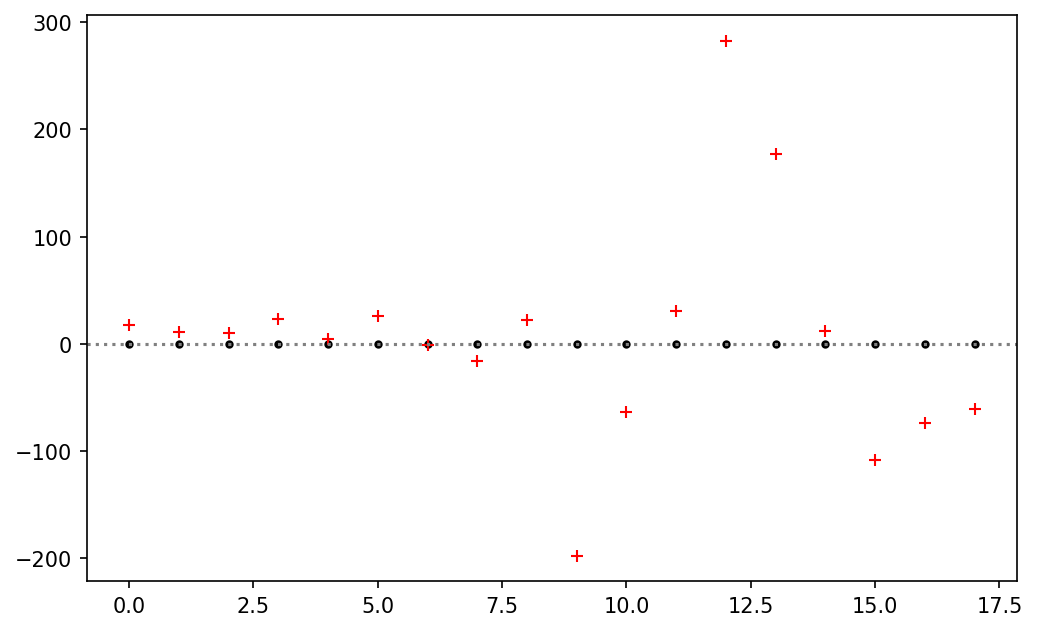

In [249]:
plt.figure(figsize=(8,5),dpi=150,facecolor='w')
plt.plot(resid, 'k.')
plt.plot(gradient/scale/100, 'r+')
plt.axhline(0, ls=':', color='gray')

In [250]:
fit_gains

array([ 1.02898879e+00,  1.01392002e+00,  1.02487005e+00,  1.01404833e+00,
        1.02880245e+00,  1.01362425e+00,  1.02799632e+00,  1.02944558e+00,
        1.01550968e+00,  3.15848623e-02,  2.88785001e-02,  2.56221805e-02,
       -2.31063156e-04, -6.18690676e-03, -7.33083213e-03, -3.42067494e-02,
       -3.74231868e-02, -4.10113594e-02])

Run comparisons against dense formulation, checking likelihood, gradient, and calibration solutions. Check analytic gradient against autodiff gradient and numerical gradient. Think about how to convert these to unit tests.

Text(0, 0.5, 'Gain Residual')

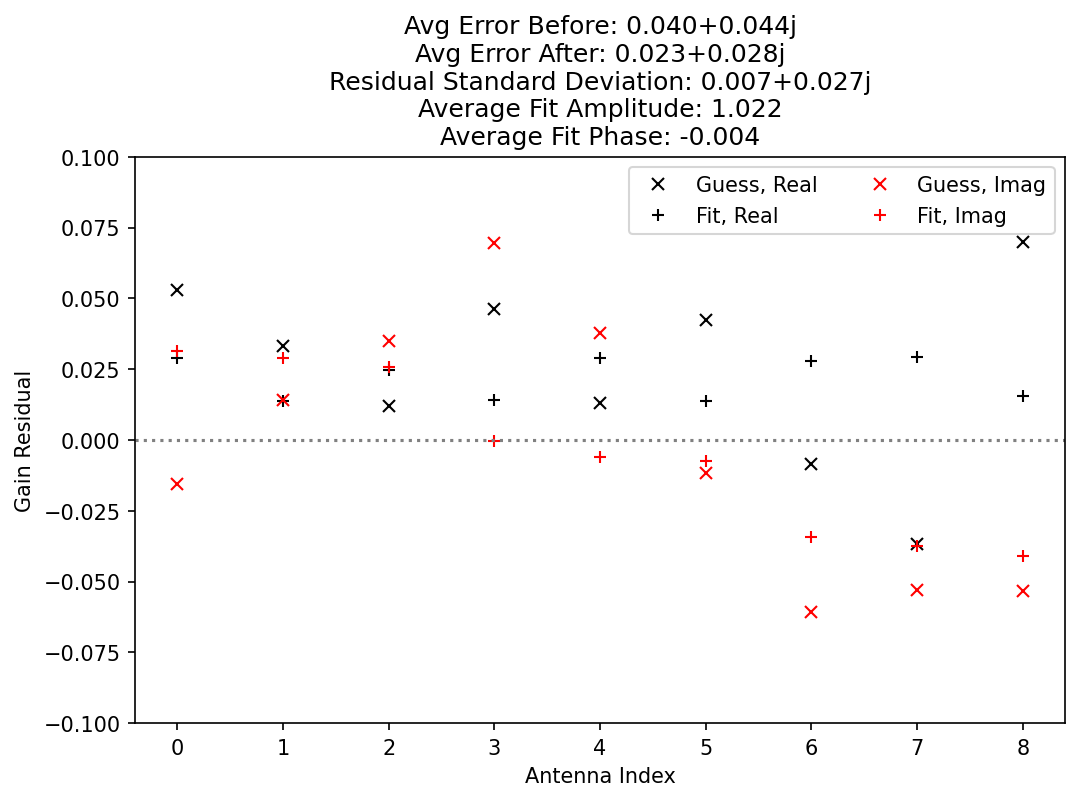

In [251]:
n_ants = gains.size
fit_gains = corrcal.linalg.SplitVec(complex_fit).data
# fit_gains = corrcal.utils.rephase_to_ant(corrcal.linalg.SplitVec(complex_fit).data)
fit = fit_gains[:n_ants] + 1j*fit_gains[n_ants:]
# fit /= np.abs(fit)
def err(val, exp):
    return np.sqrt(np.mean((val - exp)**2))
avg_err_before = err(gains.real, 1) + 1j*err(gains.imag, 0)
avg_err_after = err(fit.real, 1) + 1j*err(fit.imag, 0)
fit_std = np.std(fit.real) + 1j*np.std(fit.imag)
lim = 0.1
plt.figure(figsize=(8,5),dpi=150, facecolor='white')
title = f"Avg Error Before: {avg_err_before:.3f}\n"
title += f"Avg Error After: {avg_err_after:.3f}\n"
title += f"Residual Standard Deviation: {fit_std:.3f}\n"
title += f"Average Fit Amplitude: {np.mean(np.abs(fit)):.3f}\n"
title += f"Average Fit Phase: {np.mean(np.angle(fit)):.3f}"
plt.title(title)
plt.plot(gains.real - 1, 'kx', label='Guess, Real')
plt.plot(fit.real - 1, 'k+', label='Fit, Real')
plt.plot(gains.imag, 'rx', label='Guess, Imag')
plt.plot(fit.imag, 'r+', label='Fit, Imag')
plt.ylim(-lim,lim)
plt.axhline(0, color='gray', ls=':')
plt.legend(ncol=2)
plt.xlabel("Antenna Index")
plt.ylabel("Gain Residual")
# plt.savefig("example_sol_two_src_with_noise_sparse_cov.png", dpi=150, bbox_inches='tight')

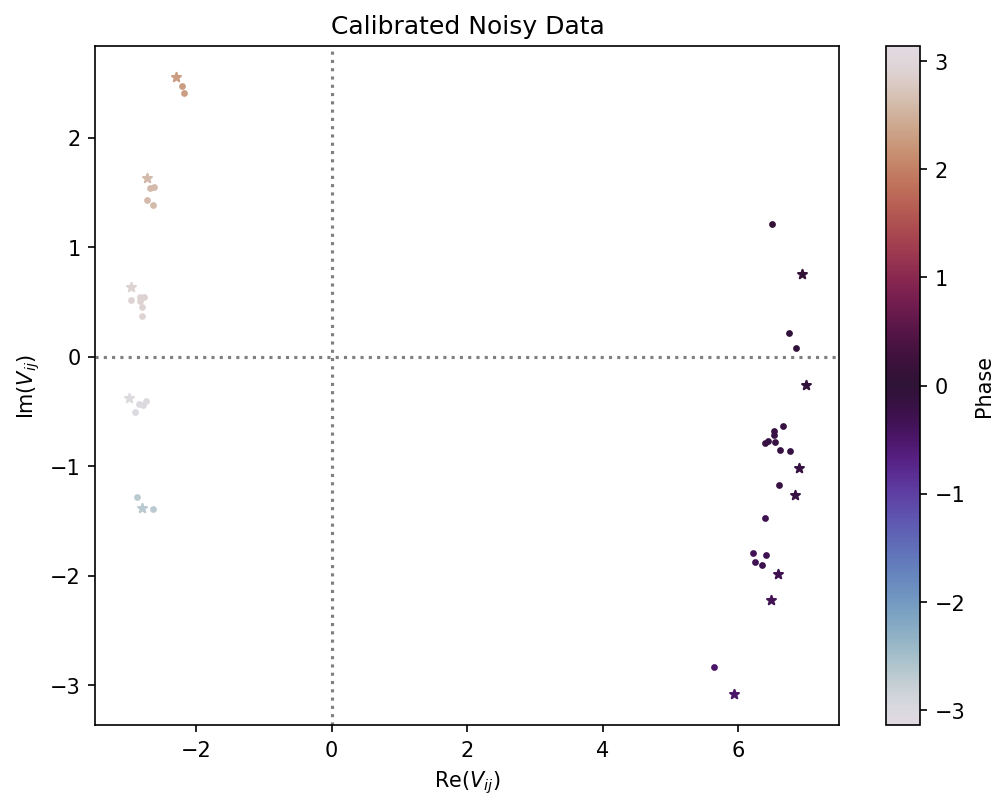

In [252]:
cal_data = sorted_data / (fit[ant_1_inds] * fit[ant_2_inds].conj())
cmap = plt.cm.twilight
norm = plt.cm.colors.Normalize(vmin=-np.pi,vmax=np.pi)
# cmap = plt.cm.gist_rainbow
# norm = plt.cm.colors.Normalize(vmin=0, vmax=len(edges)-2)
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
plt.figure(figsize=(8,6),dpi=150,facecolor='w')
for i, (left, right) in enumerate(zip(edges, edges[1:])):
    grp_data = cal_data[left:right]
    grp_data_uncal = sorted_data[left:right]
    grp_uvw = sorted_uvws[left:right].mean(axis=0)
    true_vis = np.sum(src_flux * np.exp(-2j * np.pi * grp_uvw @ src_loc.T))
    angle = np.angle(true_vis)
    color = cmap(norm(angle))
#     color = cmap(norm(i))
    plt.scatter(grp_data.real, grp_data.imag, color=color, marker='.', s=20)#, label=f"Group {i}")
#     plt.scatter(grp_data_uncal.real, grp_data_uncal.imag, color=color, marker='+', s=20)
    plt.scatter(true_vis.real, true_vis.imag, color=color, marker='*', s=20)
cbar = plt.colorbar(smap)
cbar.set_label("Phase")
plt.xlabel(r"Re$(V_{ij})$")
plt.ylabel(r"Im$(V_{ij})$")
plt.title("Calibrated Noisy Data")
plt.axvline(0, ls=':', color='k', alpha=0.5)
plt.axhline(0, ls=':', color='k', alpha=0.5)
# plt.legend(ncol=3);
# plt.savefig("calibrated_noisy_data_two_src_one_at_zenith.png", dpi=150, bbox_inches="tight")